# Stress Detection Models 

In this notebook we are going to be testing three approaches for stress detection using biosignals like Heart Rate and/or Heart Rate Variability for each one of the following datasets:

1. [Nurse Stress Prediction Wearable Sensors](https://www.kaggle.com/datasets/priyankraval/nurse-stress-prediction-wearable-sensors)
2. [Heart Rate Prediction to Monitor Stress Level](https://www.kaggle.com/datasets/vinayakshanawad/heart-rate-prediction-to-monitor-stress-level)
3. [Stress-Predict-Dataset](https://github.com/italha-d/Stress-Predict-Dataset)
4. [SWELL dataset](https://www.kaggle.com/datasets/qiriro/swell-heart-rate-variability-hrv)




In [85]:
# Import libraries
import os, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from keras import Input

warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Import Data Paths
data_path = os.getcwd() + '/data' 

---

# Nurse Stress Prediction Wearable Sensors

In [86]:
# Load the dataset
data = pd.read_csv(data_path + '/Healthcare/hrv.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332295 entries, 0 to 332294
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HR        332295 non-null  float64
 1   HRV       332295 non-null  float64
 2   datetime  332295 non-null  object 
 3   label     332295 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 12.7+ MB


## Threshold-Based Rule Engine Approach

+ Pros:
    - Easy to understand and deploy
    - No training needed

- Cons:
    - May be inaccurate
    - Doesn’t adapt to individual differences

In [87]:
def classify_stress_threshold(hrv: float, hr: float) -> str:
    if hrv < 40 and hr > 70:
        return 'high'
    elif hrv < 50 and hr > 60:
        return 'medium'
    else:
        return 'low'

In [88]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
data['stress_pred_rule'] = data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = data['label'].apply(lambda x: 'high' if x == 2 else ('medium' if x == 1 else 'low'))
labels_predictions = data['stress_pred_rule']

print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.667933613205134
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.73      0.89      0.81    246086
         low       0.03      0.00      0.01     61359
      medium       0.08      0.07      0.08     24850

    accuracy                           0.67    332295
   macro avg       0.28      0.32      0.30    332295
weighted avg       0.55      0.67      0.60    332295



## Unsupervised Learning Approach (Clustering)

- Pros:
    - No labels needed
    - Can reveal natural structure

- Cons:
    - Clusters may not match stress labels
    - Hard to evaluate accuracy directly

Kmeans Accuracy: 0.41944055733610197
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.76      0.43      0.55    246086
         low       0.20      0.50      0.29     61359
      medium       0.09      0.15      0.11     24850

    accuracy                           0.42    332295
   macro avg       0.35      0.36      0.32    332295
weighted avg       0.61      0.42      0.47    332295



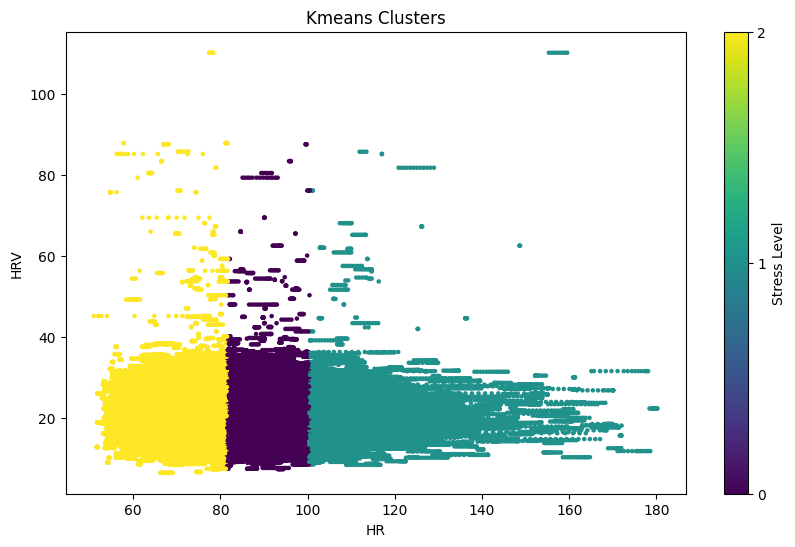

In [89]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data[['HRV', 'HR']])
data['stress_pred_kmeans'] = kmeans.predict(data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
data['stress_pred_kmeans'] = data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = data['stress_pred_kmeans']
print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(data['HR'], data['HRV'], c=data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

- Pros:
    - Learns patterns from data
    - Easy to extend with more features

- Cons:
    - Requires labeled data
    - Risk of overfitting on small or biased data

In [90]:
# Get the features and labels for the Random Forest Classifier
X = data[['HR', 'HRV']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
data['stress_pred_rf'] = clf.predict(X)
data['stress_pred_rf'] = data['stress_pred_rf'].map({0: 'low', 1: 'medium', 2: 'high'})
labels_predictions = data['stress_pred_rf']


print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.95      0.98      0.96    246086
         low       0.93      0.85      0.88     61359
      medium       0.93      0.83      0.88     24850

    accuracy                           0.94    332295
   macro avg       0.94      0.89      0.91    332295
weighted avg       0.94      0.94      0.94    332295



In [91]:
# Get the predictions of the Random Forest Classifier and encode the labels to get the accuracy of this approach
y_pred = clf.predict(X_test)

# Encode the labels to present the accuracy of this approach for the test data
y_test = y_test.map({0: 'low', 1: 'medium', 2: 'high'})
y_pred = pd.Series(y_pred).map({0: 'low', 1: 'medium', 2: 'high'})

print('The classification report matrix of the test data for the Random Forest Classifier is:\n', classification_report(y_test, y_pred))

The classification report matrix of the test data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.83      0.93      0.88     61522
         low       0.66      0.46      0.54     15340
      medium       0.64      0.38      0.48      6212

    accuracy                           0.80     83074
   macro avg       0.71      0.59      0.63     83074
weighted avg       0.79      0.80      0.79     83074



## Deep Learning Approach

In [92]:
# Feature Engineering and Scaling
features = data[['HR', 'HRV']]
labels = data['label'].astype('int32')

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [93]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=512, callbacks=callback)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6616 - loss: 1.7898 - val_accuracy: 0.7123 - val_loss: 0.9021
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7240 - loss: 0.8317 - val_accuracy: 0.7423 - val_loss: 0.7395
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7393 - loss: 0.7383 - val_accuracy: 0.7423 - val_loss: 0.7333
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7402 - loss: 0.7348 - val_accuracy: 0.7423 - val_loss: 0.7318
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7407 - loss: 0.7336 - val_accuracy: 0.7423 - val_loss: 0.7330
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7406 - loss: 0.7329 - val_accuracy: 0.7423 - val_loss: 0.7303
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7409 - loss: 0.7313 - val_accuracy: 0.7423 - val_loss: 0.7297
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7404 - loss: 0.7318 - val_accuracy: 

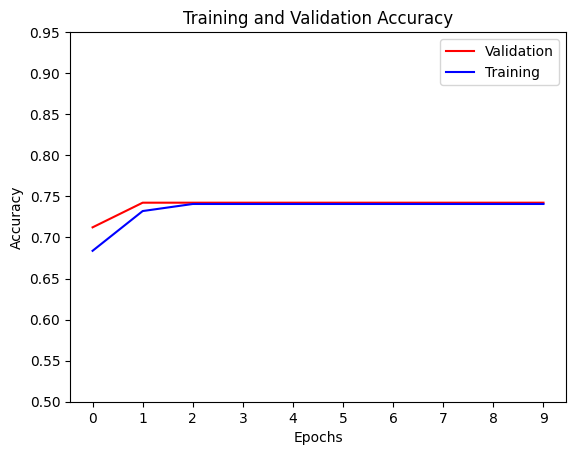

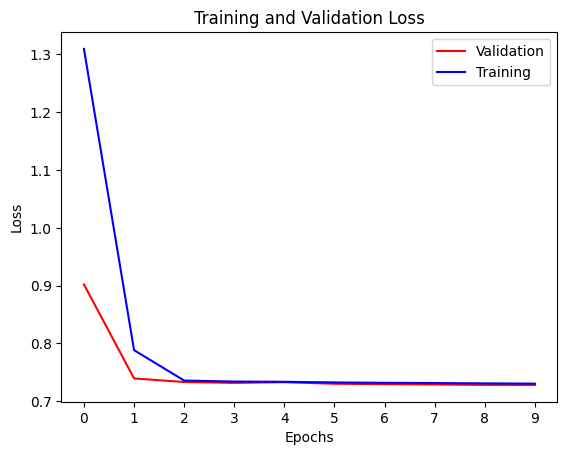

In [95]:
#Traininng Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#Traininng Visualization
plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [96]:
# Performance on Testing Data
# Evaluate the model on test data
loss, accuracy = model.evaluate(features_test, labels_test)

2077/2077 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7377 - loss: 0.7372


---

# Heart Rate Prediction to Monitor Stress Level

In [97]:
# Load the training dataset
train_data = pd.read_csv(data_path + '/Heart_Rate_Prediction/Train_Data/train.csv')
train_data = train_data.rename(columns={'RMSSD': 'HRV'})
train_data.dropna(inplace=True)

# Map the stress levels to the labels [high, medium, low]
train_data['condition'] = train_data['condition'].map({'no stress': 'low', 'interruption': 'medium', 'time pressure': 'high'})
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332307 entries, 0 to 332306
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   uuid       332307 non-null  object 
 1   condition  332307 non-null  object 
 2   HRV        332307 non-null  float64
 3   HR         332307 non-null  float64
dtypes: float64(2), object(2)
memory usage: 12.7+ MB


## Threshold-Based Rule Engine Approach

In [98]:
# Get the predictions of the rule-based model and encode the labels to get the accuracy of this approach
train_data['stress_pred_rule'] = train_data.apply(lambda row: classify_stress_threshold(row['HRV'], row['HR']), axis=1)
labels = train_data['condition']
labels_predictions = train_data['stress_pred_rule']


print('Threshold-Based Rule Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the threshold-based rule is:\n', classification_report(labels, labels_predictions, zero_division=0))

Threshold-Based Rule Accuracy: 0.193345310210137
The classification report matrix of the threshold-based rule is:
               precision    recall  f1-score   support

        high       0.17      0.89      0.29     57650
         low       0.56      0.03      0.05    180131
      medium       0.29      0.08      0.13     94526

    accuracy                           0.19    332307
   macro avg       0.34      0.33      0.16    332307
weighted avg       0.41      0.19      0.12    332307



## Unsupervised Learning Approach (Clustering)

Kmeans Accuracy: 0.37001327086098096
The classification report matrix of the Kmeans model is:
               precision    recall  f1-score   support

        high       0.17      0.36      0.24     57650
         low       0.54      0.49      0.51    180131
      medium       0.28      0.15      0.19     94526

    accuracy                           0.37    332307
   macro avg       0.33      0.33      0.31    332307
weighted avg       0.40      0.37      0.37    332307



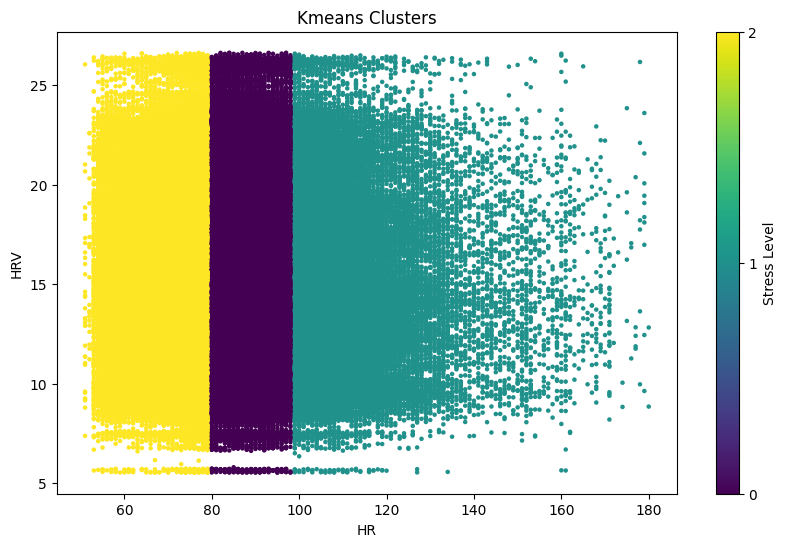

In [99]:
# Create Kmeans model with 3 clusters for the 3 classes [low, medium, high]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(train_data[['HRV', 'HR']])
train_data['stress_pred_kmeans'] = kmeans.predict(train_data[['HRV', 'HR']])

# Map the cluster labels to the stress levels
cluster_mapping = {0: 'low', 1: 'medium', 2: 'high'}
train_data['stress_pred_kmeans'] = train_data['stress_pred_kmeans'].map(cluster_mapping)

# Get the predictions of the Kmeans model and encode the labels to get the accuracy of this approach
labels_predictions = train_data['stress_pred_kmeans']

print('Kmeans Accuracy:', accuracy_score(labels, labels_predictions))
print('The classification report matrix of the Kmeans model is:\n', classification_report(labels, labels_predictions, zero_division=0))


# Plot the clusters
plt.figure(figsize=(10, 6))
plt.title('Kmeans Clusters')
plt.scatter(train_data['HR'], train_data['HRV'], c=train_data['stress_pred_kmeans'].map({'low': 0, 'medium': 1, 'high': 2}), s=5)
plt.xlabel('HR')
plt.ylabel('HRV')
plt.colorbar(ticks=[0, 1, 2], label='Stress Level')
plt.show()

## Machine Learning Approach (Random Forest)

In [100]:
# Get the features and labels for the Random Forest Classifier
X = train_data[['HR', 'HRV']]
y = train_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Create the Random Forest Classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the predictions of the Random Forest Classifier
train_data['stress_pred_rf'] = clf.predict(X)
labels_predictions = train_data['stress_pred_rf']

print('The classification report matrix of the train data for the Random Forest Classifier is:\n', classification_report(labels, labels_predictions, zero_division=0))

The classification report matrix of the train data for the Random Forest Classifier is:
               precision    recall  f1-score   support

        high       0.82      0.81      0.81     57650
         low       0.90      0.90      0.90    180131
      medium       0.85      0.84      0.85     94526

    accuracy                           0.87    332307
   macro avg       0.85      0.85      0.85    332307
weighted avg       0.87      0.87      0.87    332307



## Deep Learning Approach

In [101]:
# Feature Engineering and Scaling
num_classes = 3
features = train_data[['HR', 'HRV']]
labels   = train_data['condition'].map({'low': 0, 'medium': 1, 'high': 2})
labels = to_categorical(labels, num_classes=num_classes)

# Create the train/test split
features_train, features_test, labels_train, labels_test= train_test_split(features, labels, test_size=0.2,random_state=34)

In [105]:
# Create callback function for early stopping in case we have a decrease in accuracy
callback = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=True, mode='auto', baseline=None, restore_best_weights=True)

# Define a small learning rate for the optimizer
optimizer = keras.optimizers.Adam(0.001)


# Create the Deep Learning Model Architecture
model = Sequential()
model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(features_train.shape[1], activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85 (340.00 B)

 Trainable params: 85 (340.00 B)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Train the model
history=model.fit(features_train, labels_train, validation_split=0.1, epochs=10, verbose=True, batch_size=256, callbacks=callback)

Epoch 1/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5191 - loss: 5.9872 - val_accuracy: 0.5467 - val_loss: 0.9927
Epoch 2/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5484 - loss: 0.9953 - val_accuracy: 0.5548 - val_loss: 0.9866
Epoch 3/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5571 - loss: 0.9861 - val_accuracy: 0.5503 - val_loss: 0.9820
Epoch 4/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5590 - loss: 0.9810 - val_accuracy: 0.5349 - val_loss: 0.9921
Epoch 5/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5456 - loss: 1.0010 - val_accuracy: 0.5673 - val_loss: 0.9766
Epoch 6/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5668 - loss: 0.9731 - val_accuracy: 0.5658 - val_loss: 0.9772
Epoch 7/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5632 - loss: 0.9780 - val_accuracy: 0.5674 - val_loss: 0.9732
Epoch 8/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5627 - loss: 0.9788 - 

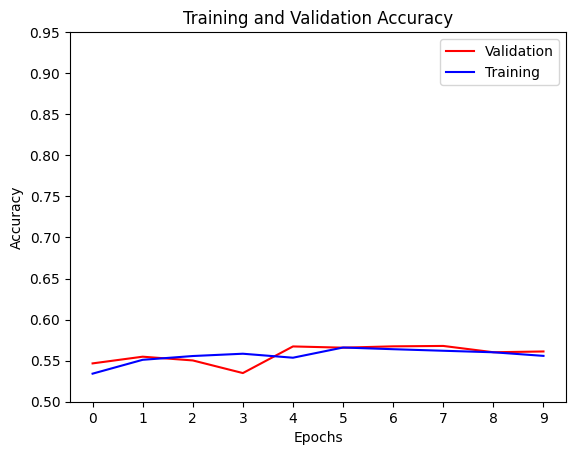

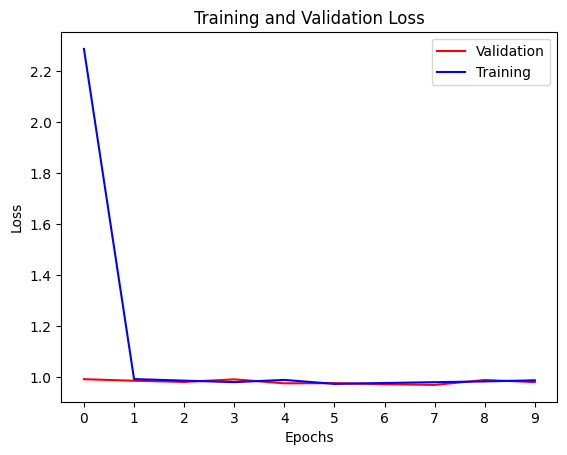

In [107]:
#Training Visualization
plt.plot(history.history['val_accuracy'],color='red',label='Validation')
plt.plot(history.history['accuracy'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['val_loss'],color='red',label='Validation')
plt.plot(history.history['loss'],color='blue',label='Training')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Epochs')    
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()